# Preliminaries

Install the needed packages.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from numba import jit, objmode, njit, prange
import pandas as pd

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import Csphere, CsphereOverSemi

In [3]:
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3, SampleModel4
from dissipationtheory.dissipation9b import SampleModel3Jit, SampleModel4Jit
from dissipationtheory.dissipation9d import twodimCobject as twodimCobject8c

In [4]:
THIS = 'dissipation-theory--Study-58--'
figs = {}
obj = {}

In [5]:
Kp = np.array([[complex(1,0), 0, 0],
               [complex(0,1), 0, 0],
               [0, complex(1,0), 0],
               [0, complex(0,1), 0],
               [0, 0, complex(1,0)],
               [0, 0, complex(0,1)]])

# Test objects

We are most interested in a semi-infinite dielectric sample and a metal, so make a Type III and Type IV sample. The Type III sample is a good test case for modeling Type I and Type II samples.

In [6]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(30, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm')
)

In [7]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')   # ignored
)
sample3_jit = SampleModel3Jit(**sample3.args())

In [8]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(100, 'nm')  # ignored
)
sample4_jit = SampleModel4Jit(**sample4.args())

# Type IV `twodimCobject` object

The `twodimCobject8c` object from `dissipation9d.py` presently has only the following functions defined: `addsphere`, `addtip`, `plot`, and `properties`.  We need to write a new `solve` funcion.  And of course the `properties` function won't work until we have a working `solve` function.

Using code previously developed, here we create a `solve` function that will work for a metal sample.  

After running the code below, we will have created

* `obj['IV'].sj` -- sample voltage-probe locations in nm
* `obj['IV'].rk` -- sample image-charge locations in nm
* `obj['IV'].zr` -- reference distance, 1 nm, a `ureg.Quantity` object with units

to play with.

## Spherical tip

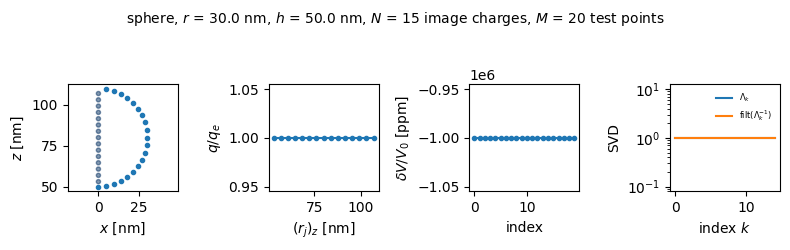

In [9]:
obj['IVa'] = twodimCobject8c(sample4_jit)

params = {'h': ureg.Quantity(50, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IVa'].addsphere(**params)
_ = obj['IVa'].plot()

## Coulomb matrix and $K_n$ matrices for a metal

Set up the Coulomb matrix that we need to enforce the constant-charge condition on the tip surface.

In [10]:
@jit(nopython=True)
def Cmatrix_jit(sj, rk):
    """The unitless Coulomb potential Green's function matrix."""    

    result = np.zeros((len(sj),len(rk)))
    for j, sje in enumerate(sj):
        for k, rke in enumerate(rk):
            result[j,k] = 1 / np.linalg.norm(sje - rke)
    return result

In [11]:
%%timeit
Cmatrix_jit(obj['IVa'].sj, obj['IVa'].rk)

283 μs ± 18.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
Cmatrix_jit(obj['IVa'].sj, obj['IVa'].rk).shape

(20, 15)

Now set up the Green's function matrices for a metal.

In [13]:
@jit(nopython=True)
def KmatrixIV_jit(sj, rk):
    """The unitless Green's function matrices for an image charge."""

    K0 = complex(1,0) * np.zeros((len(sj),len(rk)))
    K1 = complex(1,0) * np.zeros((len(sj),len(rk)))
    K2 = complex(1,0) * np.zeros((len(sj),len(rk)))

    for k, rke in enumerate(rk):
        
        # location of image charge
        rkei = rke.copy()
        rkei[2] = -1 * rkei[2]
        
        for j, sje in enumerate(sj):
            
            # shorthand
            Rinv = np.power((sje - rkei).T @ (sje - rkei), -1/2)
            
            K0[j,k] = complex( 1,0) * Rinv
            K1[j,k] = complex( 1,0) * (sje[2] + rke[2]) *  np.power(Rinv, 3)
            K2[j,k] = complex(-1,0) * (np.power(Rinv, 3) - 3 * np.power(sje[2] + rke[2], 2) * np.power(Rinv, 5))
            
    return K0, K1, K2

In [14]:
%%timeit
K0, K1, K2 = KmatrixIV_jit(obj['IVa'].sj, obj['IVa'].rk)

307 μs ± 133 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
K0, K1, K2 = KmatrixIV_jit(obj['IVa'].sj, obj['IVa'].rk)
(K0.shape, K0[0,0])

((20, 15), (0.009708737864077669+0j))

## New twodimCobject with a solve function

Use the above `Cmatrix_jit` and `KmatrixIV_jit` functions to define a new `solve` function.

In [16]:
class twodimCobject(twodimCobject8c):

    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """

        C = Cmatrix_jit(self.sj, self.rk)
        K0, K1, K2 = KmatrixIV_jit(self.sj, self.rk) 
               
        G0 = C - K0
        
        U, S, VT = np.linalg.svd(G0, full_matrices=False)
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q
  
        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr

        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        self.L0 = L0
        self.L1 = L1
        self.L2 = L2

        return L0, L1, L2

Set up a new object.

In [17]:
obj['IVb'] = twodimCobject(sample4_jit)

params = {'h': ureg.Quantity(10, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IVb'].addsphere(**params)

In [18]:
%%timeit
obj['IVb'].solve(0.)

1.89 ms ± 189 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
obj['IVb'].solve(0.)

((50.16866778928295+0j), (-1.0698343734857123+0j), (0.13354961561602843+0j))

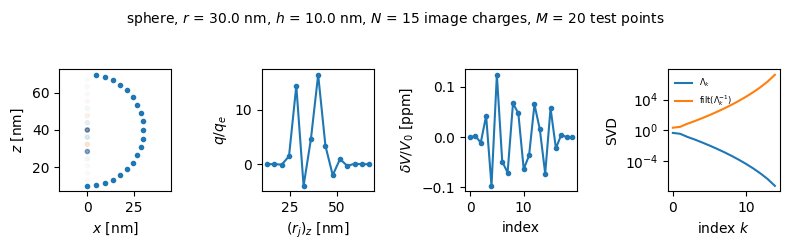

In [20]:
_ = obj['IVb'].plot()

In [21]:
%%timeit
obj['IVb'].properties()

10.5 ms ± 882 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
obj['IVb'].properties()
obj['IVb'].results['C0 [aF]']

5.582017099749146

Steal this code from [Study 54](dissipation-theory--Study-54.html).

In [23]:
def CtableMetal(sample, h_array):
    
    obj = {}
    
    for index, h in enumerate(h_array):

        obj[index] = twodimCobject(sample)

        params = {'h': h,
                  'N': 15,
                  'M': 20,
                  'theta_stop': np.pi/2, 
                  'theta_endpoint': True}
          
        obj[index].addsphere(**params)
        obj[index].properties()

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h [nm]']
        
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = Csphere(
                order, 
                ureg.Quantity(np.array([obj[index].info['h [nm]']]), 'nm'), 
                ureg.Quantity(obj[index].info['r [nm]'], 'nm'))[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]
    
    return df

An array of heights to loop over.

In [24]:
h_array = ureg.Quantity(
    np.logspace(
        start=np.log10(3e-9),
        stop=np.log10(1e-6),
        num=21,
        endpoint=True), 
    'm')

df = CtableMetal(sample4_jit, h_array)

In [25]:
h_array.shape

(21,)

To compute properties at 21 heights takes nearly 700 ms.

In [26]:
%%timeit
CtableMetal(sample4_jit, h_array)

647 ms ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The agreement is very good, except at distances less than about half the radius.

In [27]:
df

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,3.00000000,7.19356889,7.19280093,106.76795555,-486.03229046,-484.89040080,2354.94383773,179.19176869,177.29230110,10713.76239820
1,4.01111572,6.77698991,6.77679815,28.29623189,-351.24246519,-350.99842844,695.26450314,99.05945539,98.71587201,3480.52819485
2,5.36301645,6.37603280,6.37599348,6.16797686,-251.79348983,-251.75084835,169.37969568,54.54322666,54.49252918,930.35662236
3,7.17055987,5.99351665,5.99351014,1.08516640,-178.75694203,-178.75096790,33.42148311,29.87154427,29.86557487,199.87558973
4,9.58731516,5.63244338,5.63244253,0.15053749,-125.44647019,-125.44580852,5.27456146,16.24414002,16.24358833,33.96359684
5,12.81861019,5.29585824,5.29585816,0.01481537,-86.84694529,-86.84688871,0.65144427,8.75225695,8.75221712,4.55150932
6,17.13897630,4.98664760,4.98664760,0.00012578,-59.18913265,-59.18912985,0.04731733,4.66003383,4.66003170,0.45747645
7,22.91547245,4.70727786,4.70727786,-0.00035138,-39.63229026,-39.63229060,-0.00842042,2.44450974,2.44450973,0.00312397
8,30.63887063,4.45950095,4.45950095,0.00003602,-26.02821968,-26.02821979,-0.00427141,1.25932053,1.25932056,-0.01974752
9,40.96535192,4.24408022,4.24408022,0.00011399,-16.74774301,-16.74774300,0.00055036,0.63522644,0.63522644,-0.00524722


A function to plot the relative error in the capacitances versus tip-sample separation.

In [28]:
def plotme(df):
    
    h = df['h [nm]']
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.50, 3.50))  
        
        for key, label in zip(
            ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
            ['$C_0$', '$C_1$', '$C_2$']):
            y = 1e-6 * np.abs(df[key].values)
            plt.loglog(h, y, 'o-', label=label)

        plt.xlabel('tip-sample separation $h$ [nm]')
        plt.ylabel('capacitance fractional error |$\epsilon$|')
        plt.legend(frameon=True, facecolor="lightgray", framealpha=0.8, ncol=3, fontsize=9)
        fig.tight_layout()
        
        return fig

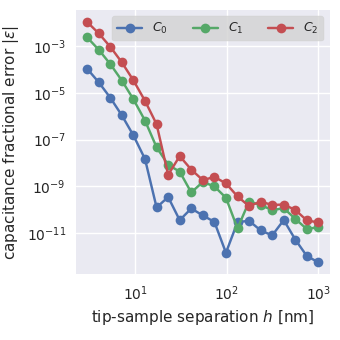

In [29]:
figs['01'] = plotme(df)

<div class="alert alert-block alert-success">
    The <tt>twodimCobject</tt> data class that accurately computes the capacitance over a metal.  
    For $h \geq R/3$, the capacitance errors are less than about 200 ppm.
</div>

Above we found that the `solve` function took 2.67 ms ± 947 μs per loop.  \
To reduce the execution time, try to make a stand-alone function `solve` that we can compile.

To make the function compileable, I have removed the computation of `Q`, `V`, and `Vrms`. \
Instead of saving `S`, `Sinv`, and `cn`, and I just saving `S`.

To avoid a compiler error involving

    TypingError: '@' arguments must all have the same dtype

I replaced

    G0inv = VT.T @ Sinv @ U.T

with 

    G0inv = VT.astype(np.complex128).T @ Sinv.astype(np.complex128) @ U.astype(np.complex128).T

and replaced 

    IdN = np.ones(self.info['N']).T
    IdM = np.ones(self.info['M'])

with 

    IdN = np.ones(rk.shape[0], dtype=np.complex128).T
    IdM = np.ones(sj.shape[0], dtype=np.complex128)    

In [30]:
@jit(nopython=True)
def solve_jit(sj, rk, cG, cGinv, omega, alpha=0.):
    """Solve for the charges.  The parameter $\alpha$ is used to filter
    the singular values in the inverse.  The parameter omega is the unitless
    cantilever frequency in rad/s.       
    """
    
    C = Cmatrix_jit(sj, rk)
    K0, K1, K2 = KmatrixIV_jit(sj, rk) 

    G0 = C - K0
    
    U, S, VT = np.linalg.svd(G0, full_matrices=False)
    filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
    Sinv = filt * np.diag(np.power(S, -1))

    G0inv = VT.astype(np.complex128).T @ Sinv.astype(np.complex128) @ U.astype(np.complex128).T
    
    IdN = np.ones(rk.shape[0], dtype=np.complex128).T
    IdM = np.ones(sj.shape[0], dtype=np.complex128)
    
    L0 = IdN @ G0inv @ IdM
    L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
    L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

    return S, Sinv, G0, G0inv, L0, L1, L2

Show we get the same answer as above.

In [31]:
args = {'sj': obj['IVb'].sj, 
        'rk': obj['IVb'].rk, 
        'cG': obj['IVb'].cG, 
        'cGinv': obj['IVb'].cGinv, 
        'omega': 0.,
        'alpha': 0.}

S, Sinv, G0, G0inv, L0, L1, L2 = solve_jit(**args)
(L0, L1, L2)

((50.16866778928295+0j), (-1.0698343734857123+0j), (0.13354961561602843+0j))

In [32]:
%%timeit
S, Sinv, G0, G0inv, L0, L1, L2 = solve_jit(**args)

570 μs ± 25.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**We have reduced the runtime of `solve` from 2.7 ms to 0.9 ms (3-fold) by writing an stand-alone, compilable program.**

Next use this compiled function to create a faster `solve` function in `twodimCobject`.  \
The member function can do nice things like compute the charge and the voltage.

In [33]:
class twodimCobject(twodimCobject8c):

    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """

        args = {'sj': self.sj, 
                'rk': self.rk, 
                'cG': self.cG, 
                'cGinv': self.cGinv, 
                'omega': omega,
                'alpha': alpha}
        
        S, Sinv, G0, G0inv, L0, L1, L2 = solve_jit(**args)
        
        self.L0 = L0 # unitless
        self.L1 = L1 # unitless
        self.L2 = L2 # unitless

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdM = np.ones(self.sj.shape[0])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q
  
        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr

        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr
        
        return L0, L1, L2

In [34]:
obj['IVc'] = twodimCobject(sample4_jit)

params = {'h': ureg.Quantity(10, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IVc'].addsphere(**params)

Really no faster, ugh!

In [35]:
%%timeit
obj['IVc'].solve(0.)

1.96 ms ± 79.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


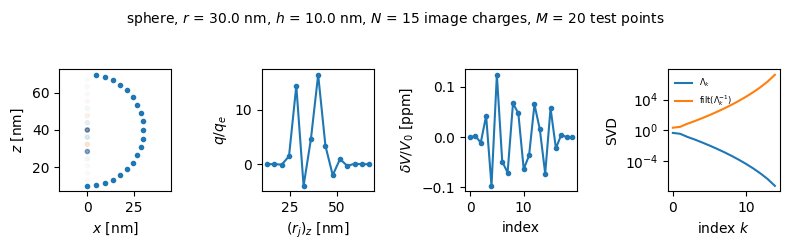

In [36]:
obj['IVc'].solve(0.)
_ = obj['IVc'].plot()

Also no faster, ugh!

In [37]:
%%timeit
obj['IVc'].properties()

9 ms ± 698 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
obj['IVc'].properties()
obj['IVc'].results['C0 [aF]']

5.582017099749146

**Compiling the core computations in `solve` did not speed up execution.  Puzzling.**

<div class="alert alert-block alert-success">
    The <tt>twodimCobject</tt> object accurately computes cantilever observables for a metallic sample in about 10 ms.
</div>

The 10 ms execution time for compiled code should be compared to *seconds* for uncompiled code. \
This speedup was achieved by creating compiled functions <tt>Cmatrix_jit</tt>, <tt>KmatrixIV_jit</tt>, and <tt>solve_jit</tt>. \
The accuracy was tested by computing the capacitance $C_0$, and capacitance derivatives $C_1$ and $C_2$, of a sphere over a metal.

## Sphere-plus-cone tip

The above new code works automatically for a sphere-plus-cone tip.

In [39]:
obj['IVd'] = twodimCobject(sample4_jit)
obj['IVd'].addtip(h=ureg.Quantity(10, 'nm'))

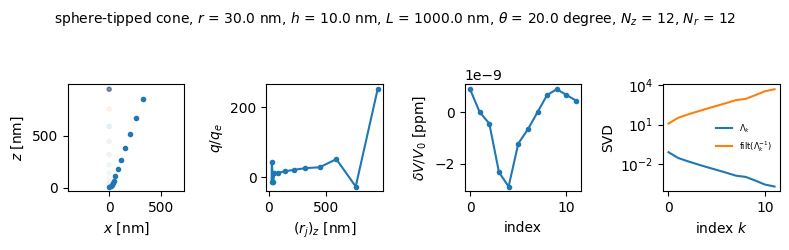

In [40]:
obj['IVd'].solve(0.)
_ = obj['IVd'].plot()

In [41]:
obj['IVd'].properties()
obj['IVd'].results['C0 [aF]']

64.64478287441288

# Type III `twodimCobject` object

**OK, now the hard part: create fast solver code for a semi-finite semiconductor.**

Write the code from scratch. \
Use the Newton-Cotes integration routine I developed in [Study 57](dissipation-theory--Study-57.html). \
The Fresnel coefficient is the new part. Create fast code to generate the Fresnel coefficient, and plot it along with the integrand.

There are two unit tests to do.  These are computing the capacitance, and capacitance derivatives, of a sphere over a
1. a semi-infinite dielectric sample (zero charge density, zero conductivity)
2. a semi-infinite metal sample (high charge density and conductivity)

Create a starter object so we have `.sj` and `.rk` matrices to work with. \
To get, create a semiconductor with low conductivity and charge density.

In [42]:
sample = {}

sample3a = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(3, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')   # ignored
)

sample['IIIa'] = SampleModel3Jit(**sample3a.args())

There are two quantities that determine the wavevector-dependence of $r_p$. \
These are the sample's inverse Debye length $1/k_{\mathrm{D}}$ and frequency $\omega_0$, printed below.

In [43]:
ureg.Quantity(1/sample['IIIa'].kD,'m').to('nm')

<Quantity(37.79777548184893, 'nanometer')>

In [44]:
ureg.Quantity(sample['IIIa'].omega0,'Hz').to('kHz')

<Quantity(11.29409067373019, 'kilohertz')>

Make a sample object.

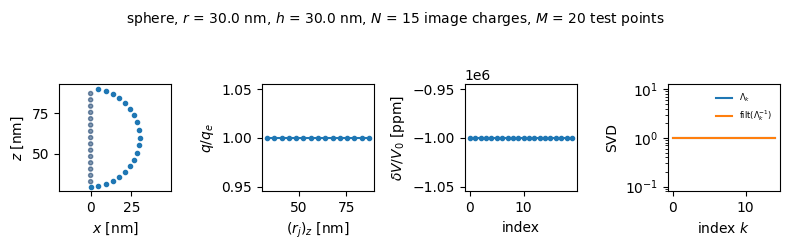

In [45]:
obj['IIIa'] = twodimCobject8c(sample['IIIa'])

params = {'h': ureg.Quantity(30, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IIIa'].addsphere(**params)
_ = obj['IIIa'].plot()

The Fresnel coefficient is the new part. Create fast code to generate the Fresnel coefficient, $r_p$, and plot it along with the integrand.

Strip down the code in `dissipation9c.py`'s `integrand3jitfast` function.

In [46]:
@jit(nopython=True)
def rpIII_jit(y, omega, omega0, zr, kD, es):
    """Fresnel coefficient for Sample III object, a semi-infinite semiconductor.
    
    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega/omega0
    k_over_eta = y / np.sqrt(y**2 + (zr * 1e-9 * kD)**2 * (1/es + complex(0,1) * Omega))

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p6 = complex(0,1) * Omega / p0

    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

Plot the $r_p$ function versus $y$ with $\omega = 11.3 \times 10^{3}$ (Hz) and $z_r = 100$ (nanometers). \
Based on the above sample parameters, this should yield a non-trivial $r_p(y)$.

In [47]:
y_vector = np.linspace(0, 20., 100)
rp_vector = np.array([rpIII_jit(
    y, 11.3e3, obj['IIIa'].sample.omega0, 100., obj['IIIa'].sample.kD, obj['IIIa'].sample.epsilon_s) 
    for y in y_vector])

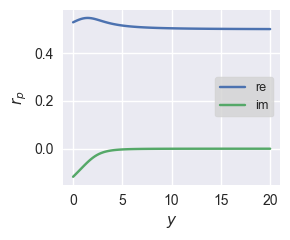

In [48]:
with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.0, 2.50))

    plt.plot(y_vector, rp_vector.real, label='re')
    plt.plot(y_vector, rp_vector.imag, label='im')
    plt.xlabel('$y$')
    plt.ylabel('$r_p$')
    plt.legend(frameon=True, facecolor="lightgray", framealpha=0.8, fontsize=9)
    fig.tight_layout()
    
    plt.show()

The $r_p$ function is non-trivial, but has no rapid oscillations that would confound my adaptive integration routine.

We now want a function to replace the line

    K0, K1, K2 = KmatrixIV_jit(sj, rk) 

in the `solve` function.  \
We'll need to pass quite more parameters to the analogous K matrix function for a Type III sample. \
I imagine a function call like this:

    K0, K1, K2 = KmatrixIII_jit(omega, omega0, kD, es, sj, rk)

The function `KmatrixIII_jit` has to handle both the looping over points *and* the integration.

In [49]:
@jit(nopython=True)
def KmatrixIII_jit(omega, omega0, kD, es, sj, rk, j0s, an):
    """The unitless response-function matrices for a Type III semiconductor sample."""

    y_min = 1.0e-7
    y_max = 20.0
    N = len(an) - 1
    
    K0 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K1 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K2 = np.zeros((len(sj),len(rk)), dtype=np.complex128)

    # Loop over image-charge points
    
    for k, rke in enumerate(rk):    

        # Loop over voltage-test points
        
        for j, sje in enumerate(sj):

            zjkref = sje[2] + rke[2]
            x = np.sqrt((sje[0] - rke[0])**2 + (sje[1] - rke[1])**2) / zjkref

            # Determine breakpoints
            
            mask = j0s/(x + 1.0e-6) < y_max
            yb = np.hstack(
                (np.array([y_min]),
                 j0s[mask] / x,
                 np.array([y_max])))
            
            result0 = np.zeros(len(yb)-1, dtype=np.complex128)
            result1 = np.zeros(len(yb)-1, dtype=np.complex128)
            result2 = np.zeros(len(yb)-1, dtype=np.complex128)

            # Loop over subintervals
            
            for index in np.arange(len(yb)-1):
                
                y_vector = np.linspace(yb[index], yb[index+1], N+1)
                dy = (yb[index+1] - yb[index])/N
            
                integral0 = np.zeros_like(y_vector, dtype=np.complex128)
                integral1 = np.zeros_like(y_vector, dtype=np.complex128)
                integral2 = np.zeros_like(y_vector, dtype=np.complex128)

                # Loop over y-axis points in the subinterval
                
                for m, y in enumerate(y_vector):

                    rp = rpIII_jit(y, omega, omega0, zjkref, kD, es)
                    
                    integral0[m] = np.exp(-y) * scipy.special.j0(y * x) * rp
                    integral1[m] = y * integral0[m]
                    integral2[m] = y * integral1[m]

                # Sum with Newton-Cotes weights
                
                result0[index] = dy * (an * integral0).sum()  
                result1[index] = dy * (an * integral1).sum()
                result2[index] = dy * (an * integral2).sum()

            K0[j,k] = result0.sum() / zjkref**1
            K1[j,k] = result1.sum() / zjkref**2
            K2[j,k] = result2.sum() / zjkref**3
            
    return K0, K1, K2

In [50]:
j0s = scipy.special.jn_zeros(0,100.)
an, _ = scipy.integrate.newton_cotes(20, 1)

In [51]:
args = {'omega': 11.3e3, 
        'omega0': obj['IIIa'].sample.omega0,
        'kD': obj['IIIa'].sample.kD, 
        'es': obj['IIIa'].sample.epsilon_s, 
        'sj': obj['IIIa'].sj, 
        'rk': obj['IIIa'].rk, 
        'j0s': j0s, 
        'an': an}

K0, K1, K2 = KmatrixIII_jit(**args)
K0[0,0]

(0.008557963954664833-0.0010480853658674401j)

In [52]:
%%timeit
K0, K1, K2 = KmatrixIII_jit(**args)

3.47 ms ± 282 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The execution time of `KmatrixIII_jit` depends on whether and how the code is compiled.

    no compilation => 250 ms ± 58.9 ms per loop
    @jit(nopython=True) => 4.55 ms ± 1.14 ms per loop
    @njit(parallel=True) => 238 ms ± 16 ms per loop

**Compilation reduces the execution time of `KmatrixIII_jit` by a factor of 55.**

Do a spot-check of the accuracy.  \
To do this, set up a metallic "semiconductor" sample with high dielectric constant, conductivity, and charge density.

In [53]:
sample3b = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(1e6, 0), ''),
    sigma = ureg.Quantity(1e7, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')   # ignored
)

sample['IIIb'] = SampleModel3Jit(**sample3b.args())

Create a spherical tip.

In [54]:
obj['IIIb'] = twodimCobject8c(sample['IIIb'])

params = {'h': ureg.Quantity(30, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IIIb'].addsphere(**params)

Compute the $K_n$ matrices for a metallic sample.

In [55]:
K0, K1, K2 = KmatrixIV_jit(obj['IIIb'].sj, obj['IIIb'].rk)
vals1 = np.array([K0[0,0], K1[0,0], K2[0,0]])
vals1

array([1.58730159e-02+0.j, 2.51952633e-04+0.j, 7.99849628e-06-0.j])

Compute the $K_n$ matrices for the "metallic" semiconductor sample.

In [56]:
args = {'omega': 11.3e3, 
        'omega0': obj['IIIb'].sample.omega0,
        'kD': obj['IIIb'].sample.kD, 
        'es': obj['IIIb'].sample.epsilon_s, 
        'sj': obj['IIIb'].sj, 
        'rk': obj['IIIb'].rk, 
        'j0s': j0s, 
        'an': an}

K0, K1, K2 = KmatrixIII_jit(**args)
vals2 = np.array([K0[0,0], K1[0,0], K2[0,0]])
vals2

array([1.58729961e-02-8.00071062e-17j, 2.51951426e-04-7.50153932e-20j,
       7.99861969e-06-1.13791537e-21j])

The first matrix elements of $K_0$, $K_1$, and $K_2$ agree for both samples to within a relative error of 15 ppm or better.

In [57]:
(vals1-vals2)/vals1

array([ 1.24261547e-06+5.04044769e-15j,  4.78960842e-06+2.97736095e-16j,
       -1.54285430e-05+1.42266162e-16j])

This agreement suggests that we have set up the $K_n$ matrices correctly for the semiconductor sample.

Now fold this function into an *uncompiled* `solve` function. \
Since we are inheriting from `twodimCobject8c` we should immediately have access to properties.

In [58]:
class twodimCobject(twodimCobject8c):

    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """

        C = Cmatrix_jit(self.sj, self.rk)

        if self.sample.type == 4:
            
            K0, K1, K2 = KmatrixIV_jit(self.sj, self.rk)
            
        elif self.sample.type == 3:

            j0s = scipy.special.jn_zeros(0,100.)
            an, _ = scipy.integrate.newton_cotes(20, 1)
            
            args = {'omega': omega, 
                'omega0': self.sample.omega0,
                'kD': self.sample.kD, 
                'es': self.sample.epsilon_s, 
                'sj': self.sj, 
                'rk': self.rk, 
                'j0s': j0s, 
                'an': an}
        
            K0, K1, K2 = KmatrixIII_jit(**args)
            
        else:

            raise Exception("unknown sample type")
               
        G0 = C - K0
        
        U, S, VT = np.linalg.svd(G0, full_matrices=False)
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q
  
        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr

        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        self.L0 = L0
        self.L1 = L1
        self.L2 = L2

        return L0, L1, L2

Create a metallic sample again.

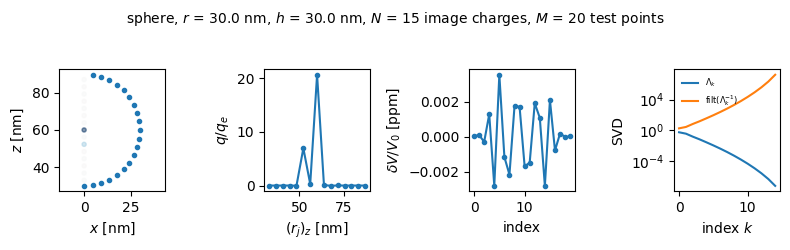

In [59]:
obj['IIIb'] = twodimCobject(sample['IIIb'])

params = {'h': ureg.Quantity(30, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IIIb'].addsphere(**params)
_ = obj['IIIb'].solve(0.)
_ = obj['IIIb'].plot()

The execution time is longer than I would like, around 50 ms to calculate properties.

In [60]:
%%timeit
obj['IIIb'].properties()

25 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
obj['IIIb'].properties()
obj['IIIb'].results['C0 [aF]']

4.476389015504537

<div class="alert alert-block alert-success">
    The <tt>twodimCobject</tt> object accurately computes cantilever observables for a semiconductor sample in about 50 ms.
</div>

Redefine the function to compare to a metal, to make sure we are incorporating the most recent version of the `twodimCobject` class.

Code from [Study 54](dissipation-theory--Study-54.html).

In [62]:
def CtableMetal(sample, h_array):
    
    obj = {}
    
    for index, h in enumerate(h_array):

        obj[index] = twodimCobject(sample)

        params = {'h': h,
                  'N': 15,
                  'M': 20,
                  'theta_stop': np.pi/2, 
                  'theta_endpoint': True}
          
        obj[index].addsphere(**params)
        obj[index].properties()

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h [nm]']
        
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = Csphere(
                order, 
                ureg.Quantity(np.array([obj[index].info['h [nm]']]), 'nm'), 
                ureg.Quantity(obj[index].info['r [nm]'], 'nm'))[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]
    
    return df

In [63]:
h_array = ureg.Quantity(
    np.logspace(
        start=np.log10(3e-9),
        stop=np.log10(1e-6),
        num=21,
        endpoint=True), 
    'm')

df = CtableMetal(sample['IIIb'], h_array)
df

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,3.00000000,7.19355237,7.19280093,104.47101022,-486.02792644,-484.89040080,2345.94382712,179.18938981,177.29230110,10700.34458067
1,4.01111572,6.77697686,6.77679815,26.37150975,-351.23978291,-350.99842844,687.62265480,99.05835317,98.71587201,3469.36258580
2,5.36301645,6.37602262,6.37599348,4.57025594,-251.79185221,-251.75084835,162.87475441,54.54272130,54.49252918,921.08257003
3,7.17055987,5.99350876,5.99351014,-0.23064216,-178.75594924,-178.75096790,27.86745103,29.87131605,29.86557487,192.23385898
4,9.58731516,5.63243735,5.63244253,-0.92117174,-125.44587427,-125.44580852,0.52418518,16.24403915,16.24358833,27.75392302
5,12.81861019,5.29585368,5.29585816,-0.84586284,-86.84658829,-86.84688871,-3.45922404,8.75221336,8.75221712,-0.42939360
6,17.13897630,4.98664420,4.98664760,-0.68089447,-59.18892202,-59.18912985,-3.51122481,4.66001504,4.66003170,-3.57537225
7,22.91547245,4.70727537,4.70727786,-0.52889419,-39.63216648,-39.63229060,-3.13163669,2.44450240,2.44450973,-2.99874611
8,30.63887063,4.45949916,4.45950095,-0.40082892,-26.02814662,-26.02821979,-2.81142181,1.25931823,1.25932056,-1.84914856
9,40.96535192,4.24407896,4.24408022,-0.29613040,-16.74769974,-16.74774300,-2.58283113,0.63522605,0.63522644,-0.61013300


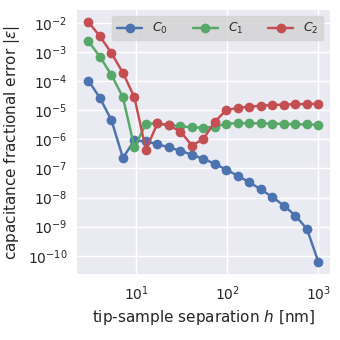

In [64]:
figs['02'] = plotme(df)

<div class="alert alert-block alert-success">
    The <tt>twodimCobject</tt> data class accurately computes the capacitance over a <b>semi-infinite semiconductor in the metallic-sample limit</b>. For $h \geq R/3$, the capacitance errors are less than about 30 ppm.
</div>

The errors are not as good as for a metallic sample, but the agreement is reasonable. \
It is not clear why the error for $C_1$ and $C_2$ does not improve at large tip-sample separation $h$. \
At large $h$, the error in $C_2$ is below about 20 ppm, which is still quite acceptable. 

Now create a dielectric with essentially no charge.

In [65]:
sample3c = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(3, 0), ''),
    sigma = ureg.Quantity(1e-10, 'S/m'),
    rho = ureg.Quantity(1e0, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')   # ignored
)

sample['IIIc'] = SampleModel3Jit(**sample3c.args())

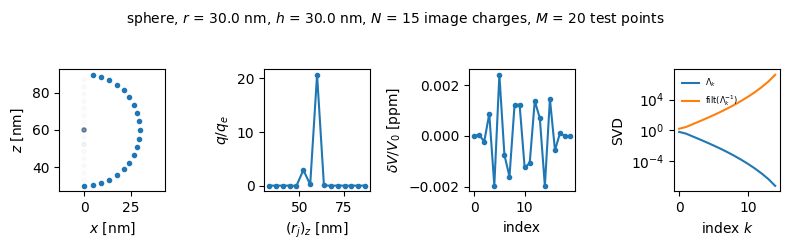

In [66]:
obj['IIIc'] = twodimCobject(sample['IIIc'])

params = {'h': ureg.Quantity(30, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IIIc'].addsphere(**params)
_ = obj['IIIc'].solve(0.)
_ = obj['IIIc'].plot()

In [67]:
obj['IIIc'].properties()
obj['IIIc'].results['C0 [aF]']

3.819429811900617

Code from [Study 54](dissipation-theory--Study-54.html).

In [68]:
def CtableDielectric(sample, h_array):
    
    obj = {}
    
    for index, h in enumerate(h_array):

        sample.z_r = h.to('m').magnitude
        
        obj[index] = twodimCobject(sample)

        params = {'h': h,
                  'N': 15,
                  'M': 20,
                  'theta_stop': np.pi/2, 
                  'theta_endpoint': False}
        
        obj[index].addsphere(**params)
        obj[index].properties()

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h [nm]']
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = CsphereOverSemi(
                order, 
                ureg.Quantity(np.array([obj[index].info['h [nm]']]), 'nm'), 
                ureg.Quantity(obj[index].info['r [nm]'], 'nm'),
                sample.epsilon_s.real)[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]
    
    return df

In [69]:
df = CtableDielectric(sample['IIIc'], h_array)
df

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,3.00000000,4.41160119,4.41160166,-0.10722721,-55.63308165,-55.63305800,0.42505930,7.55863350,7.55764962,130.18362494
1,4.01111572,4.35889687,4.35889708,-0.04694158,-48.89866759,-48.89905181,-7.85751643,5.87861550,5.87859791,2.99098885
2,5.36301645,4.29766886,4.29766864,0.05082746,-42.00752517,-42.00771789,-4.58769800,4.42647121,4.42666299,-43.32532568
3,7.17055987,4.22822960,4.22822930,0.07192355,-35.18634590,-35.18627925,1.89441640,3.22071782,3.22079848,-25.04324513
4,9.58731516,4.15153410,4.15153407,0.00650256,-28.66795187,-28.66782352,4.47697411,2.25972639,2.25971339,5.75000669
5,12.81861019,4.06922862,4.06922889,-0.06668461,-22.66716308,-22.66711032,2.32765324,1.52546952,1.52544392,16.78204344
6,17.13897630,3.98359639,3.98359672,-0.08271317,-17.35725564,-17.35727263,-0.97879566,0.98854219,0.98853254,9.76368285
7,22.91547245,3.89737903,3.89737921,-0.04512203,-12.85123578,-12.85126843,-2.54042847,0.61356756,0.61356698,0.94302229
8,30.63887063,3.81348228,3.81348230,-0.00338954,-9.19159750,-9.19161302,-1.68780772,0.36409477,0.36409608,-3.59744644
9,40.96535192,3.73461575,3.73461569,0.01637370,-6.35098528,-6.35098697,-0.26690356,0.20637549,0.20637601,-2.52332739


In [70]:
def plotme2(df):
    
    h = df['h [nm]']
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.50, 3.50))  
        
        for key, label in zip(
            ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
            ['$C_0$', '$C_1$', '$C_2$']):
            y = 1e-6 * np.abs(df[key].values)
            plt.loglog(h, y, 'o-', label=label)

        plt.xlabel('tip-sample separation $h$ [nm]')
        plt.ylabel('capacitance fractional error |$\epsilon$|')
        plt.legend(frameon=True, facecolor="lightgray", framealpha=0.8, ncol=3, fontsize=9)
        fig.tight_layout()
        
        return fig

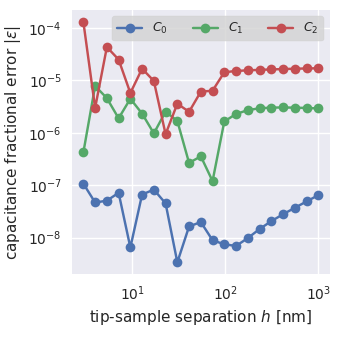

In [71]:
figs['03'] = plotme2(df)

<div class="alert alert-block alert-success">
    The <tt>twodimCobject</tt> data class that accurately computes the capacitance over a <b>semi-infinite semiconductor in the dielectric-sample limit</b>. For $h \geq R/3$, the capacitance errors are less than about 20 ppm.
</div>

Look at the $r_p$ function to understand why I set $y_{\min} = 1.0 \times 10^{-7}$ and not $y_{\mathrm{min}} = 0$.

In [72]:
obj['IIIc'].sample.print()

cantilever
        cantilever freq =  62000.0 Hz
                        =  389557.48904513434 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.0000000000000004e-08 m
        cone half angle =  20.0 degree
            cone length =  1.0000000000000002e-06 m

sample type =  3

semiconductor
          epsilon (real) =  3.0
          epsilon (imag) =  0.0
               thickness = infinite
            conductivity =  1e-10 S/m
          charge density =  1.0 m^{{-3}}
        reference height =  1e-06 m
 
      roll-off frequency =  11.29409067373019 Hz
    inverse Debye length =  0.0008366306270290836 m^{{-1}}
            Debye length =  1195.2706101031097 m


In [73]:
def y0(zr, sample_jit):
    return zr * 1e-9 * sample_jit.sample.kD / np.sqrt(sample_jit.sample.epsilon_s.real)

In [74]:
y0(10., obj['IIIc'])

4.830289177275268e-12

In [75]:
def rpIII_jit_(y, omega, zr, sample_jit):
    
    args =  {'y': y, 
             'omega': omega, 
             'omega0': sample_jit.sample.omega0, 
             'zr': zr,
             'kD': sample_jit.sample.kD, 
             'es': sample_jit.sample.epsilon_s}
    
    return rpIII_jit(**args)

In the following code, if we replace

    np.linspace(0., 20., 100)  

with

    np.linspace(1e-11, 20., 100)

where the first argument is anything larger than about `4.8e-12`, then the $r_p \rightarrow 1$ spike at $y = 0$ goes away.

In [76]:
y_vector = np.linspace(0., 20., 100)  
rp_vector = np.array([rpIII_jit_(y, 0., 10., obj['IIIc']) for y in y_vector])

In [77]:
def plotme3(y_vector, rp_vector):

    with plt.style.context('seaborn-v0_8'):
    
        fig = plt.figure(figsize=(3.0, 2.50))
    
        plt.plot(y_vector, rp_vector.real, label='re')
        plt.plot(y_vector, rp_vector.imag, label='im')
        plt.xlabel('$y$')
        plt.ylabel('$r_p$')
        plt.legend(frameon=True, facecolor="lightgray", framealpha=0.8, fontsize=9)
        fig.tight_layout()
        
        return fig

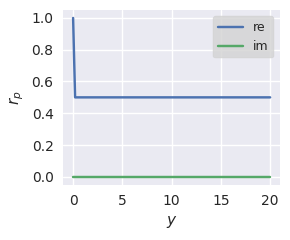

In [78]:
figs['04'] = plotme3(y_vector, rp_vector)

In [79]:
y_vector = np.linspace(4.8e-11, 20., 100)  
rp_vector = np.array([rpIII_jit_(y, 0., 10., obj['IIIc']) for y in y_vector])

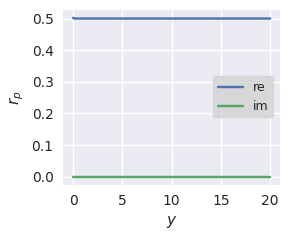

In [80]:
figs['05'] = plotme3(y_vector, rp_vector)

# Next steps

* Fold the above code into `dissipationtheory9d.py`.
* Add stand-alone unit test code.
* Create a new notebook, Study 59, where the new `twodimCobject` is demonstrated and its speed benchmarked.
* Add utility code to make it easy to benchmark $C_0$, $C_1$, and $C_2$ against sphere analytical formulas.  The code above is too repetitive.
* Modify the formulas in `properties` to include the modulation frequency.  See Loring's 06/25/25 report.
* Analyze data!

::: {.content-hidden when-format="html"}

# Save the figures

In [81]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-58.ipynb && open dissipation-theory--Study-58.html
    
:::